In [ ]:
# don't run this unless you're running SRM
!pip install brainiak

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from brainiak.funcalign.srm import SRM
from brainiak.isc import isc

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
roi = 'A1'
filepath = 'drive/MyDrive/fMRI_music_data/%s_by_subject/'%roi
subjects = ['03','15','20','23']

In [ ]:
# load data from one subject to inspect
s = '03'
test = np.loadtxt(filepath+'%s_s1%s.txt'%(roi,s))
print(test.shape)

(516, 2775)


There are 516 voxels in A1. The first three entries of each row are voxel coordinates. Then there are 18 runs of 154 TRs each. The first six TRs are zeros.

First, load in the data from all subjects for processing.

In [4]:
data = []

# load in the data from each subjects and append it to the list
for subj in subjects: data.append(np.loadtxt(filepath+'%s_s1%s.txt'%(roi,subj)))

# check the size of the list and its elements
print(len(data))
print(data[0].shape)

# recast the list into an array and check the shape
data = np.asarray(data)
print(data.shape)

4
(516, 2775)
(4, 516, 2775)


Process the data to remove unnecessary elements and runs. We're not using the control conditions for this analysis so we only keep the first twelve runs (the runs with scrambled conditions). 

In [5]:
# crop the first three entries of each row (voxel coordinates)
data = data[:,:,3:]
print('without voxel coords: ', data.shape)

# reshape into runs
data = np.reshape(data,(4,516,18,154))

# crop the six empty TRs at the beginning of each run
# drop the control conditions
data = data[:,:,:12,6:]
print('final data shape: ', data.shape)

without voxel coords:  (4, 516, 2772)
final data shape:  (4, 516, 12, 148)


For this analysis, we're interested in event segmentation in run 1 of the 8B condition. Since subjects played the conditions in a counterbalanced order, the run of interest is in a different location in each subject's data. Which run is 8B run 1 is recorded in the 'loc' variable.

For each subject, copy the data to a temporary variable (`this_data`). Take the run of interest and append it to `test_data` then delete it from `this_data`. Then, take the rest of that subject's data and append it to `train_data`.


In [6]:
loc = [0,1,2,2]

train_data = []
test_data = []

for s in range(len(subjects)):
  subj = subjects[s]
  this_data = np.copy(data[s,:,:,:])

  # append the run of interest to test_data
  test_data.append(this_data[:,loc[s],:])

  # delete the run from this_data
  this_data = np.delete(this_data,loc[s],1)

  # append the rest of the data to train_data
  train_data.append(this_data)

In [7]:
# recast our lists into arrays
train_data = np.array(train_data)
test_data = np.array(test_data)

# sanity check
print(train_data.shape)
print(test_data.shape)

(4, 516, 11, 148)
(4, 516, 148)


First, we'll take a look at the TRxTR matrix for 8B run 1, averaged across subjects.

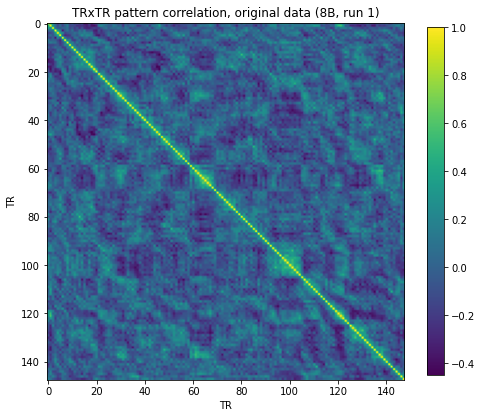

In [20]:
# average the data across subjects
avg_test_data = np.average(test_data,axis=0)

# compute the correlation TR by TR and plot
m_orig = np.corrcoef(avg_test_data, rowvar=False)
fig,ax = plt.subplots(figsize=(8,8))
im = ax.imshow(m_orig)
fig.colorbar(im,shrink=0.8)
ax.set_title('TRxTR pattern correlation, original data (8B, run 1)')
ax.set_ylabel('TR')
ax.set_xlabel('TR');

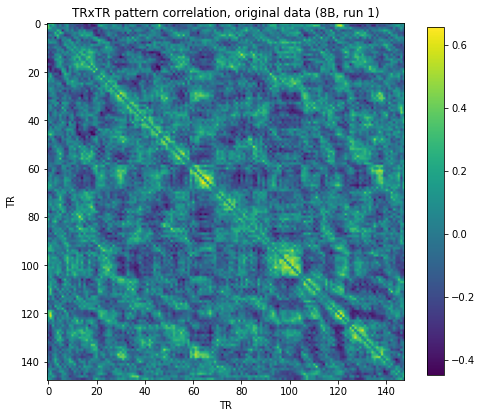

In [21]:
# set the diagonal to zero for better visualization
m_orig_zero = np.copy(m_orig) 
np.fill_diagonal(m_orig_zero,0)
fig,ax = plt.subplots(figsize=(8,8))
im = ax.imshow(m_orig_zero)
fig.colorbar(im,shrink=0.8)
ax.set_title('TRxTR pattern correlation, original data (8B, run 1)')
ax.set_ylabel('TR')
ax.set_xlabel('TR');

To prepare training data for SRM, we reshape the data so that the third dimension contains all time points across all runs. `order = 'C'` (default) in `np.reshape` keeps the runs themselves intact.

In [8]:
train_data = np.reshape(train_data,(train_data.shape[0],train_data.shape[1],-1))

In [9]:
print(train_data.shape)

(4, 516, 1628)


In [10]:
# normalize data in time for each subject
for s in range(len(subjects)):
  train_data[s] = stats.zscore(train_data[s],axis=1)
  test_data[s] = stats.zscore(test_data[s],axis=1)

As a test of SRM, we first run the outer loop only of our cross-validation setup. We set the number of features (k) to 30, fit the SRM to the training data, then transform the test data. The outcome measure is the difference in average ISC between the original data and SRM-transformed data.

SRM code borrowed in part from BrainIAK tutorial 11 (SRM).

In [11]:
features = 30
n_iter = 20 

# create the SRM object
srm = SRM(n_iter=n_iter, features=features)

# fit the SRM data
srm.fit(train_data)
print('SRM has been fit')

SRM has been fit


In [12]:
shared_test = srm.transform(test_data)

In [20]:
# for ISC, data has to be TRs x voxels/features x subjects
shared_test = np.asarray(shared_test)
shared_test = np.transpose(shared_test,axes=[2,1,0])
print(shared_test.shape)

(148, 30, 4)


In [22]:
shared_test_isc = isc(shared_test)
print(shared_test_isc.shape)

# average ISC values across subjects
isc_by_feat = np.average(shared_test_isc,axis=0)
print(isc_by_feat.shape)

(4, 30)
(30,)


Compare average ISC for the 30 features with average ISC for the original voxels.

In [24]:
# reshape the original data for ISC
test_data = np.transpose(test_data,axes=[2,1,0])
print(test_data.shape)

(148, 516, 4)


In [25]:
test_isc = isc(test_data)
print(test_isc.shape)

# average ISC values across subjects
isc_by_voxel = np.average(test_isc,axis=0)
print(isc_by_voxel.shape)

(4, 516)
(516,)


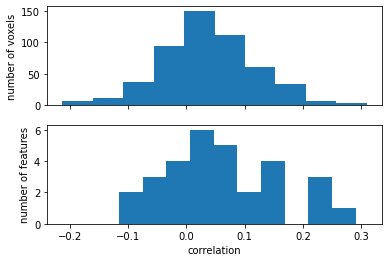

In [28]:
# compare the two distributions
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].hist(isc_by_voxel)
ax[0].set_ylabel('number of voxels')
ax[1].hist(isc_by_feat)
ax[1].set_ylabel('number of features')
ax[1].set_xlabel('correlation');

In [29]:
print('voxelwise ISC mean: ', np.average(isc_by_voxel))
print('feature-wise ISC mean: ', np.average(isc_by_feat))

voxelwise ISC mean:  0.03674215960207243
feature-wise ISC mean:  0.06035768563584639


What if we compute ISC averaged over all voxels or features in the ROI?

In [32]:
print(test_data.shape)
print(shared_test.shape)

(148, 516, 4)
(148, 30, 4)


In [33]:
# average over all voxels or features
avg_test = np.average(test_data,axis=1)
avg_shared = np.average(shared_test,axis=1)
print(avg_test.shape)
print(avg_shared.shape)

(148, 4)
(148, 4)


In [34]:
avg_test = np.reshape(avg_test,(avg_test.shape[0],1,avg_test.shape[1]))
avg_shared = np.reshape(avg_shared,(avg_shared.shape[0],1,avg_shared.shape[1]))
print(avg_test.shape)
print(avg_shared.shape)

(148, 1, 4)
(148, 1, 4)


In [35]:
avg_test_isc = isc(avg_test)
print(avg_test_isc.shape)

avg_shared_isc = isc(avg_shared)
print(avg_shared_isc.shape)

(4, 1)
(4, 1)


In [38]:
# average over subjects
print('ISC mean for original data: ', np.average(avg_test_isc))
print('ISC mean for SRM-transformed data: ', np.average(avg_shared_isc))

ISC mean for original data:  0.2618504267617523
ISC mean for SRM-transformed data:  -0.02930974213983652


It seems like it's unhelpful to average over voxels and features when computing ISC.